# Lab for answering question C
Responsible: Moritz Renkin
Question: Are there trends visible that could be due to climate change?

In [248]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
%run -i utility_functions.py

Loading the files from the transformation notebook

In [249]:
transformed_df_serial_path = "../data/data_transformed.pickle"

with open(transformed_df_serial_path, "rb") as file:
    df: pd.DataFrame = pickle.load(file)

assert isinstance(df, pd.DataFrame),f"The serialized object in {transformed_df_serial_path} is not a pandas dataframe!"
assert len(df)!=0, "The serialized dataframe contains no data!"


with open("../data/country_temp_delta.pickle", "rb") as file:
    country_temp_delta: pd.DataFrame = pickle.load(file)

In [250]:
population_raw = pd.read_csv('../data/population.csv',skiprows=4) # TODO remove
yearly_country_population = population_raw\
    .drop(["Unnamed: 66", "Indicator Name", "Indicator Code", "Country Code"], axis=1)\
    .melt(id_vars="Country Name",
          var_name="Year",
          value_name="Population")\
    .rename(columns={"Country Name": "Country"})\
    .set_index(["Year", "Country"])["Population"]

yearly_country_population

Year  Country                    
1960  Aruba                              54608.0
      Africa Eastern and Southern    130692579.0
      Afghanistan                      8622466.0
      Africa Western and Central      97256290.0
      Angola                           5357195.0
                                        ...     
2021  Kosovo                           1786038.0
      Yemen, Rep.                     32981641.0
      South Africa                    59392255.0
      Zambia                          19473125.0
      Zimbabwe                        15993524.0
Name: Population, Length: 16492, dtype: float64

Loading the disaster classification

In [251]:
disaster_classification: pd.DataFrame = pd.read_csv("../data/disaster_classification.csv")
disaster_subgroups = set(disaster_classification.loc[disaster_classification["Disaster Sub-Group"].notna(), "Disaster Sub-Group"])

Loading the NASA yearly global temperature data, source: [https://climate.nasa.gov/vital-signs/global-temperature/](https://climate.nasa.gov/vital-signs/global-temperature/)

In [252]:
yearly_global_temp: pd.DataFrame = pd.read_csv("../data/nasa_yearly_global_temperature.csv", index_col="Year").rename(columns={"Temp_No_Smoothing": "Temperature Delta"})
yearly_global_temp

,Temperature Delta,Temp_Lowess(5)
Year,,
1880,-0.18,-0.10
1881,-0.09,-0.14
1882,-0.11,-0.17
1883,-0.17,-0.20
1884,-0.28,-0.24
...,...,...
2017,0.92,0.91
2018,0.85,0.92
2019,0.98,0.93


Dumping all data before 1950 as it is not relevant to climate change.

In [284]:
cutoff_year = 1950 # TODO check
df = df[df["Start_Year"] >= cutoff_year]
min_year = df["Start_Year"].min()
max_year = df["Start_Year"].max()

yearly_global_temp = yearly_global_temp[yearly_global_temp.index >= cutoff_year]

Dumping extra-terrestrial and geophysical disasters can be assumed to be indifferent to climate change

In [285]:
df = df[(df["Disaster_Subgroup"] != "Extra-terrestrial") & (df["Disaster_Subgroup"] != "Geophysical")]
yearly_disaster_deaths = get_yearly_deaths(df, include_zero=True) # remove

## Regarding Groupby and Pandas Datatypes

Pandas usually uses numpy datatypes. However, **numpy integer arrays do not allow for null values (np.nan)**. That's why pandas introduces their own Integer array, which can inlcude null values (pd.NA). However, for groupby operations these pd.NA values can cause problems, so it is advisable to convert back to a numpy float array (which does allow for np.nan) before applying the groupby.

In [255]:
groupby_base = df.astype({"Total_Deaths": np.float64, "Total_Affected": np.float64, "Start_Year": np.int32, "Disaster_Decade": np.int32})
groupby_base = groupby_base[groupby_base["Disaster_Decade"] < 2020]
groupby_base[["Disaster_Subgroup", "Total_Deaths"]].groupby(["Disaster_Subgroup"]).mean()

,Total_Deaths
Disaster_Subgroup,
Biological,215.214689
Climatological,9342.864979
Hydrological,554.114710
Meteorological,332.690490


## Data Exploration

In [256]:
year_range = range(min_year, max_year)

def fill_missing_year():
    set(groupby_base.groupby("Start_Year").size().rename("No_Disasters").index).difference(year_range)
    # TODO

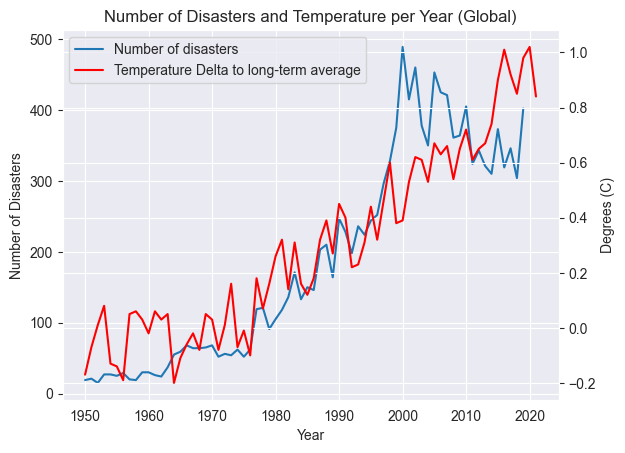

Correlation Coefficient: 0.8886333511376328


In [257]:
total_disaster_per_year = get_yearly_disaster_count(groupby_base, include_zero=True)

fig, ax_dis = plt.subplots()

plot_dis = ax_dis.plot(total_disaster_per_year.index, total_disaster_per_year, label="Number of disasters")
ax_dis.set_ylabel("Number of Disasters")
ax_dis.set_xlabel("Year")
ax_temp = ax_dis.twinx()

plot_temp = ax_temp.plot(yearly_global_temp.index, yearly_global_temp["Temperature Delta"], color="r", label="Temperature Delta to long-term average")
ax_temp.set_ylabel("Degrees (C)")

plots = plot_dis + plot_temp
plt.legend(plots, [plot.get_label() for plot in plots])
plt.title("Number of Disasters and Temperature per Year (Global)")

plt.show()
print(f"Correlation Coefficient: {total_disaster_per_year.corr(yearly_global_temp['Temperature Delta'])}")

The plot above shows that there has been an overall increase in the number of yearly disaster occurrences in the considered time frame.
At the same time, there is a trend of increasing global temperature.
The correlation between the two values over the considered time frame is quite high, but this correlation does not prove a causal influence.
We will be looking exploring general trends in the different disaster subgroups/types before trying to relate them to climate change.

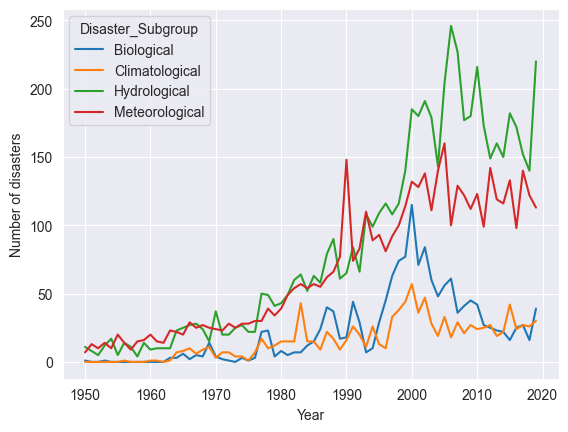

In [258]:
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Subgroup"]).reset_index(),
             x="Start_Year",
             y="No_Disasters",
             hue="Disaster_Subgroup")
plt.ylabel("Number of disasters")
plt.xlabel("Year")
plt.title("") # TODO
plt.show()

<AxesSubplot: xlabel='Start_Year', ylabel='No_Disasters'>

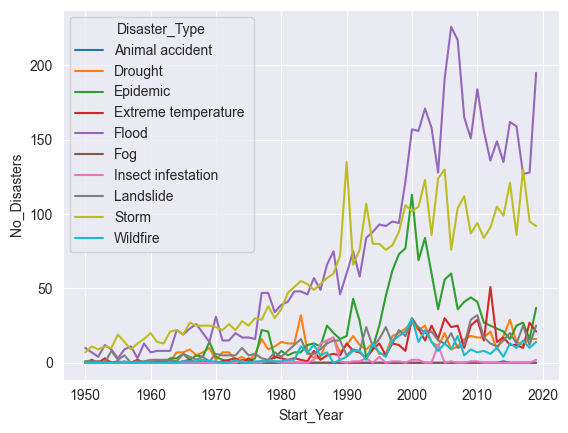

In [259]:
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Type"]).reset_index(),
             x="Start_Year",
             y="No_Disasters",
             hue="Disaster_Type")

## Global trends related to rising temperature

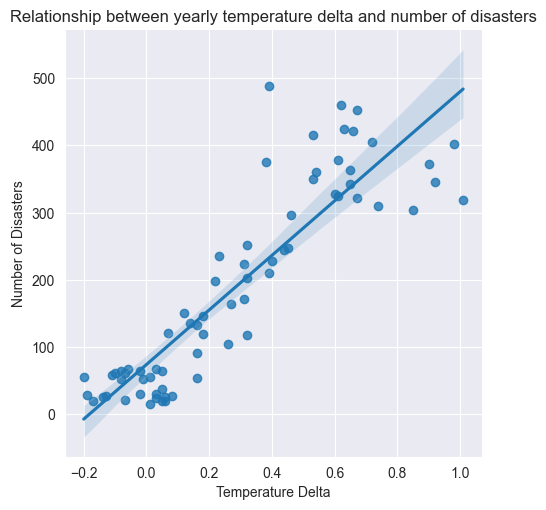

Correlation coefficient: 0.8886333511376328


In [260]:
yearly_temp_disasters = pd.concat((yearly_global_temp, get_yearly_disaster_count(groupby_base)), axis="columns")#.rename_axis("Year")
yearly_temp_disasters["Disaster_Decade"] = yearly_temp_disasters.index//10*10
sns.lmplot(data=yearly_temp_disasters,
           x="Temperature Delta",
           y="No_Disasters")
plt.xlabel("Temperature Delta")
plt.ylabel("Number of Disasters")
plt.title("Relationship between yearly temperature delta and number of disasters")
plt.show()
print(f"Correlation coefficient: {yearly_temp_disasters['Temperature Delta'].corr(yearly_temp_disasters['No_Disasters'])}")

In the graph above, a linear regression is depicted to show the supposed impact of rising temperatures on the number of natural disaster occurrences. Specially, the linear regression is performed on the global temperature delta of a given year to long-term average (x-axis) and the Number of natural disasters in that year (y-axis).

Text(54.09334852430557, 0.5, 'Number of disasters')

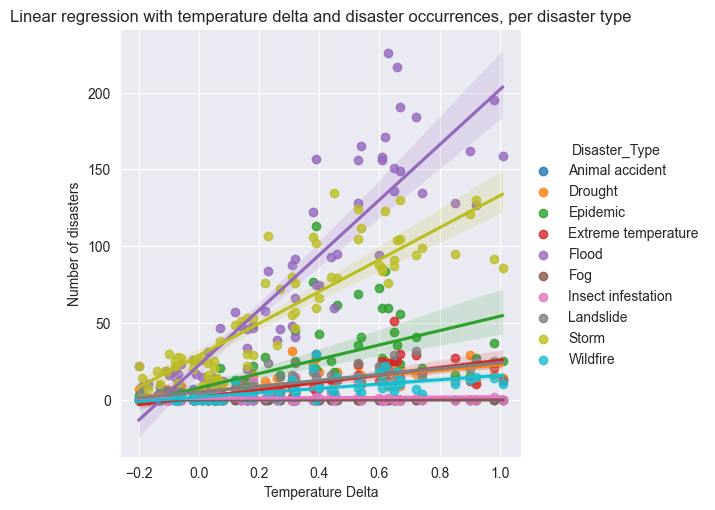

In [261]:
yearly_disaster_temp_by_subgroup: pd.DataFrame = get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Type"]).to_frame()
yearly_disaster_temp_by_subgroup["Temperature Delta"] = 0
yearly_disaster_temp_by_subgroup["Temperature Delta"] = yearly_disaster_temp_by_subgroup["Temperature Delta"].add(yearly_temp_disasters["Temperature Delta"].rename_axis(index="Start_Year"))#.groupby("Disaster_Decade")["Temperature Delta"].mean().drop(2020))
yearly_disaster_temp_by_subgroup.reset_index(inplace=True)

sns.lmplot(data=yearly_disaster_temp_by_subgroup,
           x="Temperature Delta",
           y="No_Disasters",
           hue="Disaster_Type")
plt.title("Linear regression with temperature delta and disaster occurrences, per disaster type")
plt.ylabel("Number of disasters")

Similar to the previous graph, this one tries to show the relationship between increasing temperature and the number of disaster occurrences. For this graphic, though, the regression is performed for each disaster type independently. It has to be noted that the natural disaster occurrences here are in **absolute** numbers, not relative to a long-term average or similar.
Disaster type "Flood" and "Storm" have the steepest slope which corresponds to their linear regression coefficients. Note that this does not mean that they also are the most strongly correlated to temperature. We will investigate the correlation per disaster type next.

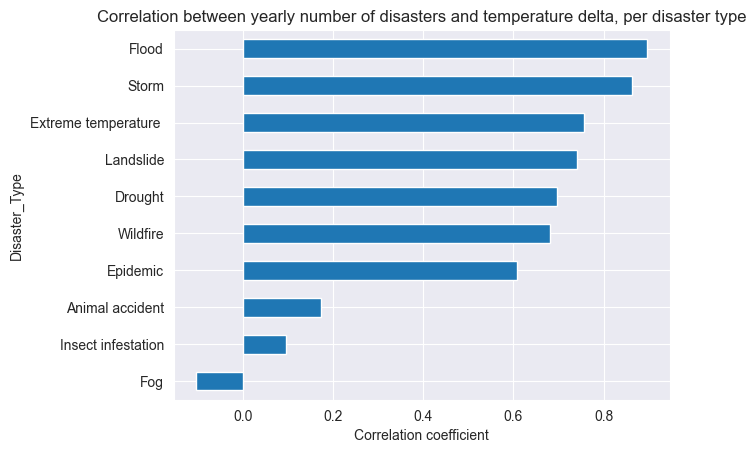

In [262]:
subgroup_correlations = yearly_disaster_temp_by_subgroup.groupby("Disaster_Type", as_index=True, group_keys=True).apply(lambda dis_type: dis_type["No_Disasters"].corr(dis_type["Temperature Delta"])).rename("Correlation").sort_values(ascending=True)
subgroup_correlations.plot.barh()
plt.xlabel("Correlation coefficient")
plt.title("Correlation between yearly number of disasters and temperature delta, per disaster type")
plt.show()

Similar to our linear regression models from before, flood and storm occurrences show the highest correlation to the yearly temperature, with both disaster types having a correlation coefficient higher than 0.8.

As noted before, **no causal influence can be assumed due to a strong correlation alone**. We are merely looking at trends here.

## Country-specific trends due to temperature increase
In this section, we try to investigate a potential trend of specific countries and their respective frequency of disaster occurrences. The hypothesis is that Countries which experienced a relatively strong warming also have a stronger trend of more frequent natural disaster occurrences.
We calculate the linear regression coefficient for Year (X) and number disaster occurrences (y) as a measure of this trend. The result of this calculation is saved in the "Disaster Occurrence Trend" column shown below. The values of this column can be interpreted as an estimator for absolute yearly increase in disaster occurrences.

In [280]:
yearly_country_disasters = get_yearly_disaster_count(groupby_base, index_cols=["Start_Year", "Country"], include_zero=True)
disaster_occurrence_trend = yearly_country_disasters.groupby(level="Country", sort=False).apply(lambda country: linregress(country, country.index.get_level_values("Start_Year")).slope).rename("Disaster Occurrence Trend")


yearly_country_deaths = get_yearly_deaths(df, custom_index=["Country"], include_zero=True)
disaster_death_trend = yearly_country_deaths.groupby(level="Country").apply(lambda country: linregress(country.index.get_level_values("Year"), country).slope).rename("Disaster Deaths Trend")

countries_complete = pd.concat((country_temp_delta, disaster_occurrence_trend, disaster_death_trend), axis="columns", join="inner")
countries_complete

,Region,Warming/Century,Uncertainty (±),Disaster Occurrence Trend,Disaster Deaths Trend
Country,,,,,
Afghanistan,Asia,3.32,0.34,4.642134,7.316071
Albania,Europe,1.97,0.28,13.169659,0.022954
Algeria,Africa,2.86,0.28,6.726465,0.843268
American Samoa,NaN,1.43,0.57,9.584615,-0.052388
Angola,Africa,1.61,0.34,8.512264,3.466155
...,...,...,...,...,...
Uruguay,South America,1.56,0.45,13.841310,0.018697
Uzbekistan,Asia,2.72,0.29,16.969697,0.042824
Yemen,Asia,2.50,0.55,10.784651,1.860530


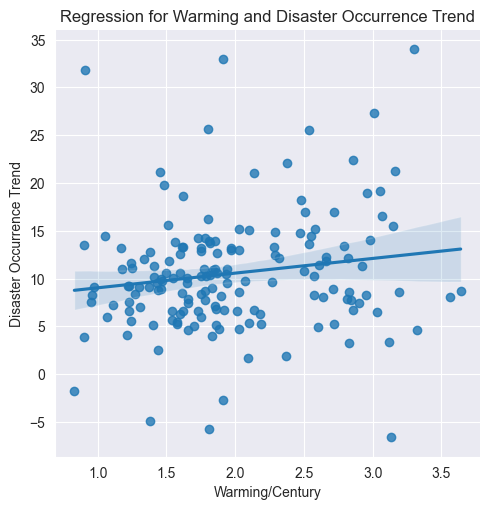

Correlation coefficient: 0.15749030996600916


In [281]:
sns.lmplot(data=countries_complete,
           x="Warming/Century",
           y="Disaster Occurrence Trend")
plt.title("Regression for Warming and Disaster Occurrence Trend")
plt.show()
print(f"Correlation coefficient: {countries_complete['Warming/Century'].corr(countries_complete['Disaster Occurrence Trend'])}")

It is pretty obvious that from the scatter plot and regression above that with our chosen method, no influence of a countries warming and disaster occurrence trend can be shown. The correlation coefficient of these two measures is low with ~0.15. Our initial hypothesis is not supported by the data.

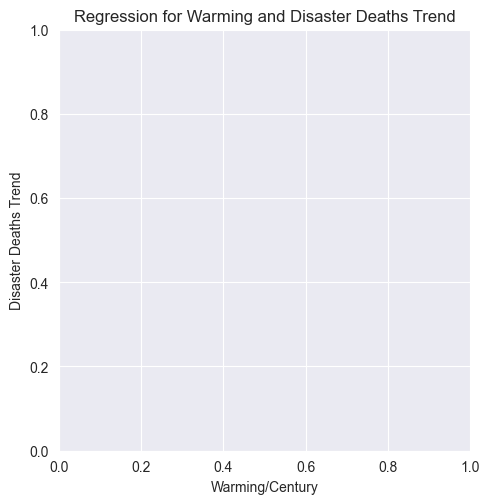

Correlation coefficient: nan


In [266]:
sns.lmplot(data=countries_complete,
           x="Warming/Century",
           y="Disaster Deaths Trend")
plt.title("Regression for Warming and Disaster Deaths Trend")
plt.show()
print(f"Correlation coefficient: {countries_complete['Warming/Century'].corr(countries_complete['Disaster Deaths Trend'])}")

Backup